# Recommendation systems: Deep Model

**Links**
* [Deep Learning With Keras: Recommender Systems](https://www.johnwittenauer.net/deep-learning-with-keras-recommender-systems/)
* [Collaborative Filtering for Movie Recommendations](https://keras.io/examples/structured_data/collaborative_filtering_movielens/)
* [Movie lens datasets](https://grouplens.org/datasets/movielens/)
* [Recommendation Systems Benchmarks](https://paperswithcode.com/task/recommendation-systems)

In [3]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [4]:
import sys
sys.path.append('./src')

import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from callback import MetricsPlotter
from util import tf_detected_devices, tf_version, plot_model, dataframe_to_dataset
from model import EmbeddingDenseModelFactory, Recommender, ValueIndexMapper, Model
from data import InMemoryXyDataGenerator, MovieLensDataSource, Dataset

### Check environment

Show GPU model:

In [5]:
!nvidia-smi --query-gpu=gpu_name,memory.total --format=csv | sed -n 2p

GeForce GTX 1060, 6078 MiB


Let's check tensorflow version:

In [6]:
tf_version()

'Tensorflow version: 2.4.0-dev20200924'

Let's check devices that tensorflow detect:

In [7]:
tf_detected_devices()

,Name,Device Type,Memory,Description
0,/device:CPU:0,CPU,256M,
1,/device:GPU:0,GPU,4G,"device: 0, name: GeForce GTX 1060, pci bus id:..."


In [8]:
tf.debugging.set_log_device_placement(False)

In [9]:
tf.test.is_built_with_cuda()

True

In [10]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

### Download dataset

Create a data source to download and read dataset files:

In [11]:
print('Dataset sizes:', MovieLensDataSource.sizes())

Dataset sizes: ['ml-latest-small', 'ml-25m', 'ml-latest']


Check: [Movie lens datasets](https://grouplens.org/datasets/movielens/)

In [12]:
ds = MovieLensDataSource(size = 'ml-latest')

In [13]:
dataset = ds.dataset()

Available files:

In [14]:
print(ds.files())

['ratings.csv', 'genome-scores.csv', 'links.csv', 'movies.csv', 'genome-tags.csv', 'tags.csv']


Rating that users give to each movie:

In [15]:
dataset.ratings().head()

,userId,movieId,rating,timestamp,user,movie
0,1,307,3.5,1256677221,0,304
1,1,481,3.5,1256677456,0,477
2,1,1091,1.5,1256677471,0,1069
3,1,1257,4.5,1256677460,0,1229
4,1,1449,4.5,1256677264,0,1414


Movie catalog: Each movie has a tittle and a list of genres.

In [16]:
dataset.movies().head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


Tags that users put to movies: Each line of this file after the header row represents one tag applied to one movie by one user.

In [17]:
dataset.tags().head()

,userId,movieId,tag,timestamp
0,14,110,epic,1443148538
1,14,110,Medieval,1443148532
2,14,260,sci-fi,1442169410
3,14,260,space action,1442169421
4,14,318,imdb top 250,1442615195


**Links** file contains one row by movie and eack column represent the movie id for each movie site:

* **movieId**: is an identifier for movies used by <https://movielens.org>. E.g., the movie Toy Story has the link <https://movielens.org/movies/1>.

* **imdbId**: is an identifier for movies used by <http://www.imdb.com>. E.g., the movie Toy Story has the link <http://www.imdb.com/title/tt0114709/>.

* **tmdbId**: is an identifier for movies used by <https://www.themoviedb.org>. E.g., the movie Toy Story has the link <https://www.themoviedb.org/movie/862>

**Note**: It will we usefull when we test each model.

In [18]:
dataset.links().head()

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


## Analize and prepare the required data

First, get 15 users with highest total ratings sum: 

In [19]:
dataset.highest_user_ratings(limit=15).head()

,rating
userId,
123100,23715
117490,9279
134596,8381
212343,7884
242683,7515


Get 15 moviles with highest total ratings sum:

In [20]:
dataset.highest_movie_ratings(limit=15).head()

,rating
movieId,
318,97999
356,97040
296,92406
593,87899
2571,84545


Show users vs. movies ratings: It can appresciated that some user did not give a rating to some movies (NaN).

In [21]:
dataset.top_user_vs_movies(limit=30)

movieId,1,32,47,50,110,150,260,296,318,356,...,1198,1210,1270,2028,2571,2858,2959,4993,5952,7153
userId,,,,,,,,,,,,,,,,,,,,,
4796,2.5,3.5,2.0,3.5,2.0,3.5,5.0,3.0,3.5,3.5,...,3.5,3.0,3.5,3.5,2.5,4.5,2.0,3.0,3.5,2.5
7705,4.5,4.0,3.5,4.0,3.5,3.0,4.5,4.0,5.0,3.5,...,5.0,4.0,3.5,3.0,4.5,4.5,4.5,3.0,4.0,2.5
37046,4.0,4.5,4.0,4.0,5.0,2.5,4.0,5.0,3.0,4.5,...,4.5,3.0,4.0,3.5,4.5,3.0,2.5,5.0,4.0,4.5
48470,4.5,3.5,4.5,4.5,4.5,2.5,4.0,5.0,4.5,4.0,...,3.0,3.5,4.0,4.0,3.5,4.0,3.5,4.0,4.0,3.5
60950,4.5,4.0,4.0,5.0,3.5,4.0,4.5,4.5,4.0,4.5,...,4.5,5.0,4.0,4.5,4.5,5.0,5.0,4.5,3.0,4.5
63783,5.0,5.0,5.0,5.0,1.0,4.0,5.0,5.0,5.0,4.0,...,4.0,5.0,4.0,4.0,5.0,5.0,5.0,5.0,4.0,4.0
66462,3.0,3.5,3.0,5.0,4.5,3.5,4.0,2.0,4.0,3.0,...,5.0,3.5,3.0,4.0,3.0,3.0,NaN,NaN,NaN,NaN
73145,NaN,3.5,3.5,4.0,3.5,4.0,5.0,3.5,4.5,4.0,...,4.0,4.5,5.0,4.5,2.5,4.0,3.0,3.0,3.0,3.5
77609,3.0,3.0,3.0,4.0,4.0,3.0,3.0,4.0,4.0,4.0,...,4.0,3.0,3.0,4.0,4.0,4.0,2.0,4.0,3.5,4.0


Users and movies count:

In [22]:
n_users, n_movies = dataset.n_users(), dataset.n_movies()
n_users, n_movies

(283228, 53889)

Min and max rating:

In [23]:
min_rating, max_rating = dataset.min_rating(), dataset.max_rating()
min_rating, max_rating

(0.5, 5.0)

Build X and y sets (Equivalent to features and label for ech training test).

In [24]:
X = dataset.ratings()[['user', 'movie']].values
y = dataset.ratings()['rating'].values

Show features an label for first sample:

In [25]:
X[0], y[0]

(array([  0, 304]), 3.5)

Split data to train, validation and test sets:

In [26]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.01) # , random_state=42)

X_train.shape, X_val.shape, y_train.shape, y_val.shape

((27475909, 2), (277535, 2), (27475909,), (277535,))

### Deep Model: User and Movie embeddings + Dense layers 

In [27]:
batch_size=100000

def to_input(X, y): return [X[:, 0], X[:, 1]], y

training_generator = InMemoryXyDataGenerator(
    X_train, 
    y_train, 
    batch_size, 
    shuffle=True, 
    to_input=to_input
)

validation_generator = InMemoryXyDataGenerator(
    X_val, 
    y_val, 
    batch_size, 
    to_input=to_input
)

In [28]:
def evaluate_xy_model(model, X, y, batch_size):
    data_generator = InMemoryXyDataGenerator(X, y, len(y), to_input=to_input)
    X_t, y_t = data_generator[0]
    print(X_t[0].shape)
    return model.evaluate(X_t, y_t, batch_size=batch_size, verbose=0)

In [29]:
model = EmbeddingDenseModelFactory.create(
    n_users, 
    n_movies, 
    n_factors=60,
    min_rating=min_rating, 
    max_rating=max_rating,
    units=[100],
    dropout=[0, 0]
)

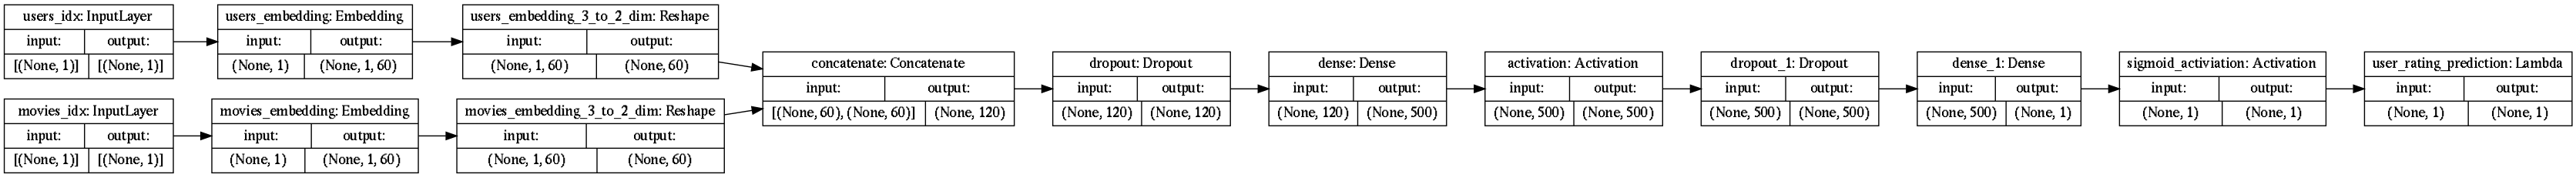

In [30]:
plot_model(model)

In [31]:
model.summary()

Model: "Embedding_Feature_Layers_Plus_Dense_Layer_Model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
users_idx (InputLayer)          [(None, 1)]          0                                            
__________________________________________________________________________________________________
movies_idx (InputLayer)         [(None, 1)]          0                                            
__________________________________________________________________________________________________
users_embedding (Embedding)     (None, 1, 60)        16993680    users_idx[0][0]                  
__________________________________________________________________________________________________
movies_embedding (Embedding)    (None, 1, 60)        3233340     movies_idx[0][0]                 
____________________________________________________

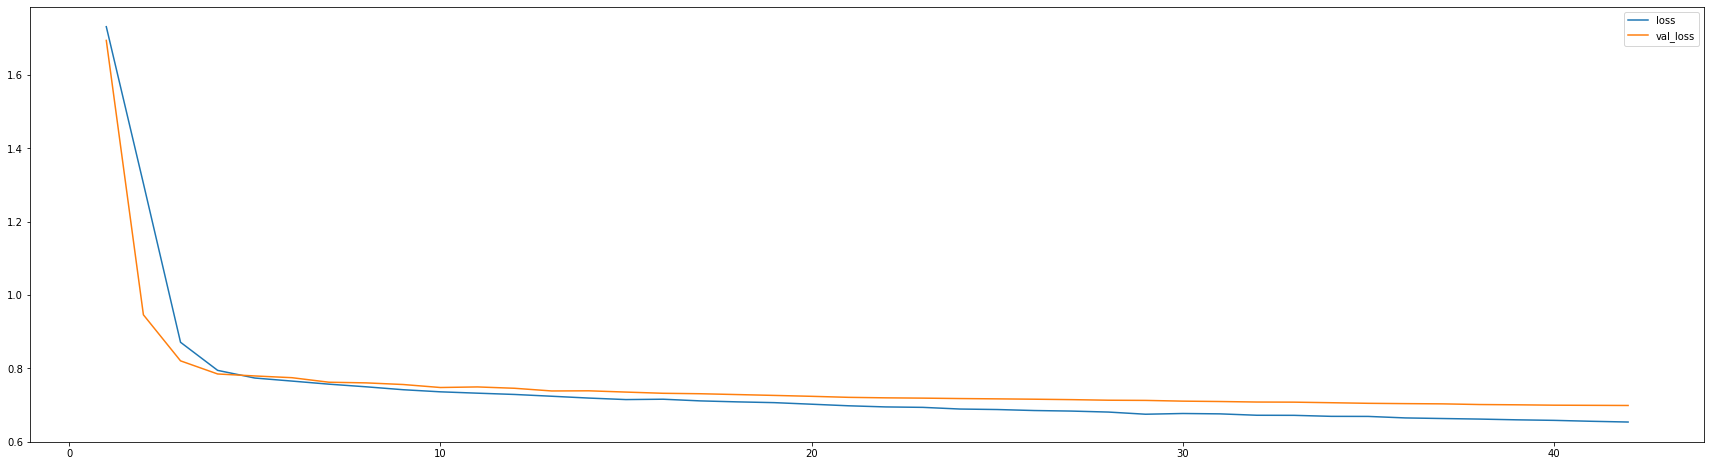

274/274 [==============================] - 279s 1s/step - loss: 0.6705 - val_loss: 0.6980


In [30]:
history = model.fit_generator(
    generator=training_generator,
    validation_data=validation_generator,
    epochs=3,
    verbose=1, 
    callbacks=[
        MetricsPlotter(
            validation_generator=validation_generator, 
            metrics_names=['loss'],
            plot_interval=15,
            evaluate_interval=20,
            batch_size=batch_size
        )
    ]
)

In [35]:
evaluate_xy_model(model, X_val, y_val, batch_size)

(277535,)


0.6512702703475952

In [32]:
# model.save_weights('./deep_model_weights.h5')

In [33]:
model.load_weights('./deep_model_weights.h5')

### Check rating prediction

In [71]:
import random

class UserMovieIdxPairGenerator:
    def __init__(self, train_input, dataset):
        self.__train_input = pd.DataFrame(X, columns=['user', 'movie'])
        self.__dataset = dataset

    def rand_user_idx(self): return random.choice(self.__train_input['user'])
 
    def rand_movie_idx(self): return random.choice(self.__train_input['movie'])
 
    def generate(self, has_rating=True):
        finish = True
        user_idx, movie_idx = None, None
        while finish:
            user_idx, movie_idx = self.rand_user_idx(), self.rand_movie_idx()
            pair = self.__dataset.rating_of(user_idx, movie_idx)
            finish = pair.empty if has_rating else not pair.empty
        return user_idx, movie_idx

In [72]:
pair_generator = UserMovieIdxPairGenerator(X, dataset)

In [81]:
user_idx, movie_idx = pair_generator.generate(has_rating=True)
dataset.rating_of(user_idx, movie_idx)

,user,movie,userId,movieId,rating,title,genres
0,57799,49,57800,50,2.5,"Usual Suspects, The (1995)",Crime|Mystery|Thriller


In [82]:
user_idx, movie_idx = pair_generator.generate(has_rating=False)
dataset.rating_of(user_idx, movie_idx)

,user,movie,userId,movieId,rating,title,genres


Predict a non-existent rating:

In [85]:
user_idx, movie_idx = pair_generator.generate(has_rating=False)
Model(model).predict_rating(user_idx=104, movie_idx=0)

,movie,predicted_rating
0,0,3.825855


In [86]:
 dataset.rating_of(user_idx, movie_idx)

,user,movie,userId,movieId,rating,title,genres


Predict ratings used to train model:

In [99]:
def rand_compare_train_rating():
    user_idx, movie_idx = pair_generator.generate()
    movie_ratting = dataset.rating_of(user_idx, movie_idx)
    predicted_movie_ratting = Model(model).predict_rating(user_idx, movie_idx)
    result = pd.merge(movie_ratting, predicted_movie_ratting, how='left', on='movie')
    return result[['user', 'movie', 'title', 'predicted_rating', 'rating']]

In [100]:
rand_compare_train_rating()

,user,movie,title,predicted_rating,rating
0,183232,512,Renaissance Man (1994),2.35042,2.0


In [101]:
rand_compare_train_rating()

,user,movie,title,predicted_rating,rating
0,39400,293,Pulp Fiction (1994),3.557112,3.0


In [102]:
rand_compare_train_rating()

,user,movie,title,predicted_rating,rating
0,170029,1445,Liar Liar (1997),3.176703,4.0


In [103]:
rand_compare_train_rating()

,user,movie,title,predicted_rating,rating
0,261025,902,"Wizard of Oz, The (1939)",3.806526,3.5


In [104]:
rand_compare_train_rating()

,user,movie,title,predicted_rating,rating
0,28772,376,True Lies (1994),3.500784,3.0


In [105]:
rand_compare_train_rating()

,user,movie,title,predicted_rating,rating
0,79314,2677,"Sixth Sense, The (1999)",3.385073,3.0


### Check recommendations

In [106]:
recommender = Recommender(model, dataset)

#### Top movies for a user

In [107]:
def rand_compare_top_movies():
    user_id = random.choice(dataset.user_ids())
    print(f'User Id: {user_id}\n')
    display(recommender.top_movies_by_user_id(user_id, limit=10))

In [108]:
rand_compare_top_movies()

User Id: 262823



,predicted_rating,title,movieId,movie
7533,4.865538,Band of Brothers (2001),170705,44359
2560,4.859451,Planet Earth (2006),159817,40073
8461,4.851930,Planet Earth II (2016),171011,44496
6630,4.832669,The Adventures of Sherlock Holmes and Doctor W...,147286,35564
110,4.820972,"Shawshank Redemption, The (1994)",318,315
154,4.820508,Schindler's List (1993),527,523
993,4.815344,Voices from the List (2004),86504,17152
10113,4.808488,"Civil War, The (1990)",93040,18776
6131,4.802338,The Adventures of Sherlock Holmes and Dr. Wats...,146028,35071
215,4.791939,Star Wars: Episode V - The Empire Strikes Back...,1196,1171


#### Similar movies

In [109]:
def rand_similar_movies():
    movie_id = random.choice(dataset.movie_ids())
    print(f'Movie\n')
    display(dataset.movie_by_id(movie_id))
    print(f'Similars (Unordered)')
    display(recommender.movies_similar_to(movie_id, limit=5))

In [110]:
rand_similar_movies()

Movie



,movieId,title,genres
7909,8592,"Wheeler Dealers, The (1963)",Comedy


Similars (Unordered)


,movieId,title,genres
7909,8592,"Wheeler Dealers, The (1963)",Comedy
38546,149672,The Human Contract (2008),Drama
43200,160660,Gli ultimi saranno ultimi (2015),Comedy|Drama
52441,180841,Interlude In Prague (2017),(no genres listed)
54197,184655,Krotoa (2017),Drama|Romance


#### Similar users

In [111]:
def rand_similar_users():
    user_id = random.choice(dataset.user_ids())
    print(f'User Id: {user_id}\n')
    print(f'Similars (Unordered): {recommender.users_similar_to(user_id, limit=10)}')

In [112]:
rand_similar_users()

User Id: 258514

Similars (Unordered): [258514, 178873, 61713, 206847, 164954, 237490, 168817, 110735, 137326, 70566]
